In [1]:
# Python Standard Libraries
import os

# Python Scientific Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Project Libraries
import lib.exp4 as exp4
import lib.reconstruction.errors as errs
import lib.reconstruction.features as ftrs
import lib.reconstruction.neighbors as nbrs

import lib.utility_functions as uf
import lib.util.datatype_utilities as dtutils

# Config
sns.set_style('white')
sns.set_context('paper')

pd.set_option('display.max_columns', 40)

% matplotlib inline

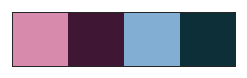

In [2]:
colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)
sns.palplot(colors)

In [3]:
colors = dict(zip(['real', 'fake', 'trained', 'untrained'], colors))

In [4]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)
tidy['Num Dif'] = tidy['Num Pieces (final)'] - tidy['Num Pieces']

vals = ['Black Position', 'White Position', 'Is Real', 'Num Pieces']

board_set = tidy.pivot_table(index='Position ID', values=vals, aggfunc=lambda x: x.unique()[0])[vals]

In [5]:
mean_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces']
)

mean_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

std_piv = tidy.pivot_table(
    index='Subject ID', values='Total Errors', columns=['Is Real', 'Num Pieces'],
    aggfunc=np.std
)

std_piv['Condition'] = mean_piv.index.map(lambda x: tidy.loc[tidy['Subject ID'] == x, 'Condition'].values[0])

In [6]:
tidy['x'] = tidy['Num Pieces']

# tidy['y'] = tidy['Type I Errors'] / (36 - tidy['Num Pieces'])
# tidy['y'] = tidy['Type II Errors'] / tidy['Num Pieces']
tidy['y'] = tidy['Type III Errors'] / tidy['Num Pieces']

In [7]:
c_filter = mean_piv['Condition'] == 'Trained'
tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True

def errbar_plot(df, ax, label, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', values='y', columns='Num Pieces'
    )
    
    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std() / np.sqrt(len(piv))

    ax.errorbar(
        x, y, yerr=err, 
        alpha=.9, color=colors[label.lower()], label=label,
        **kwargs
    )
    
    return None

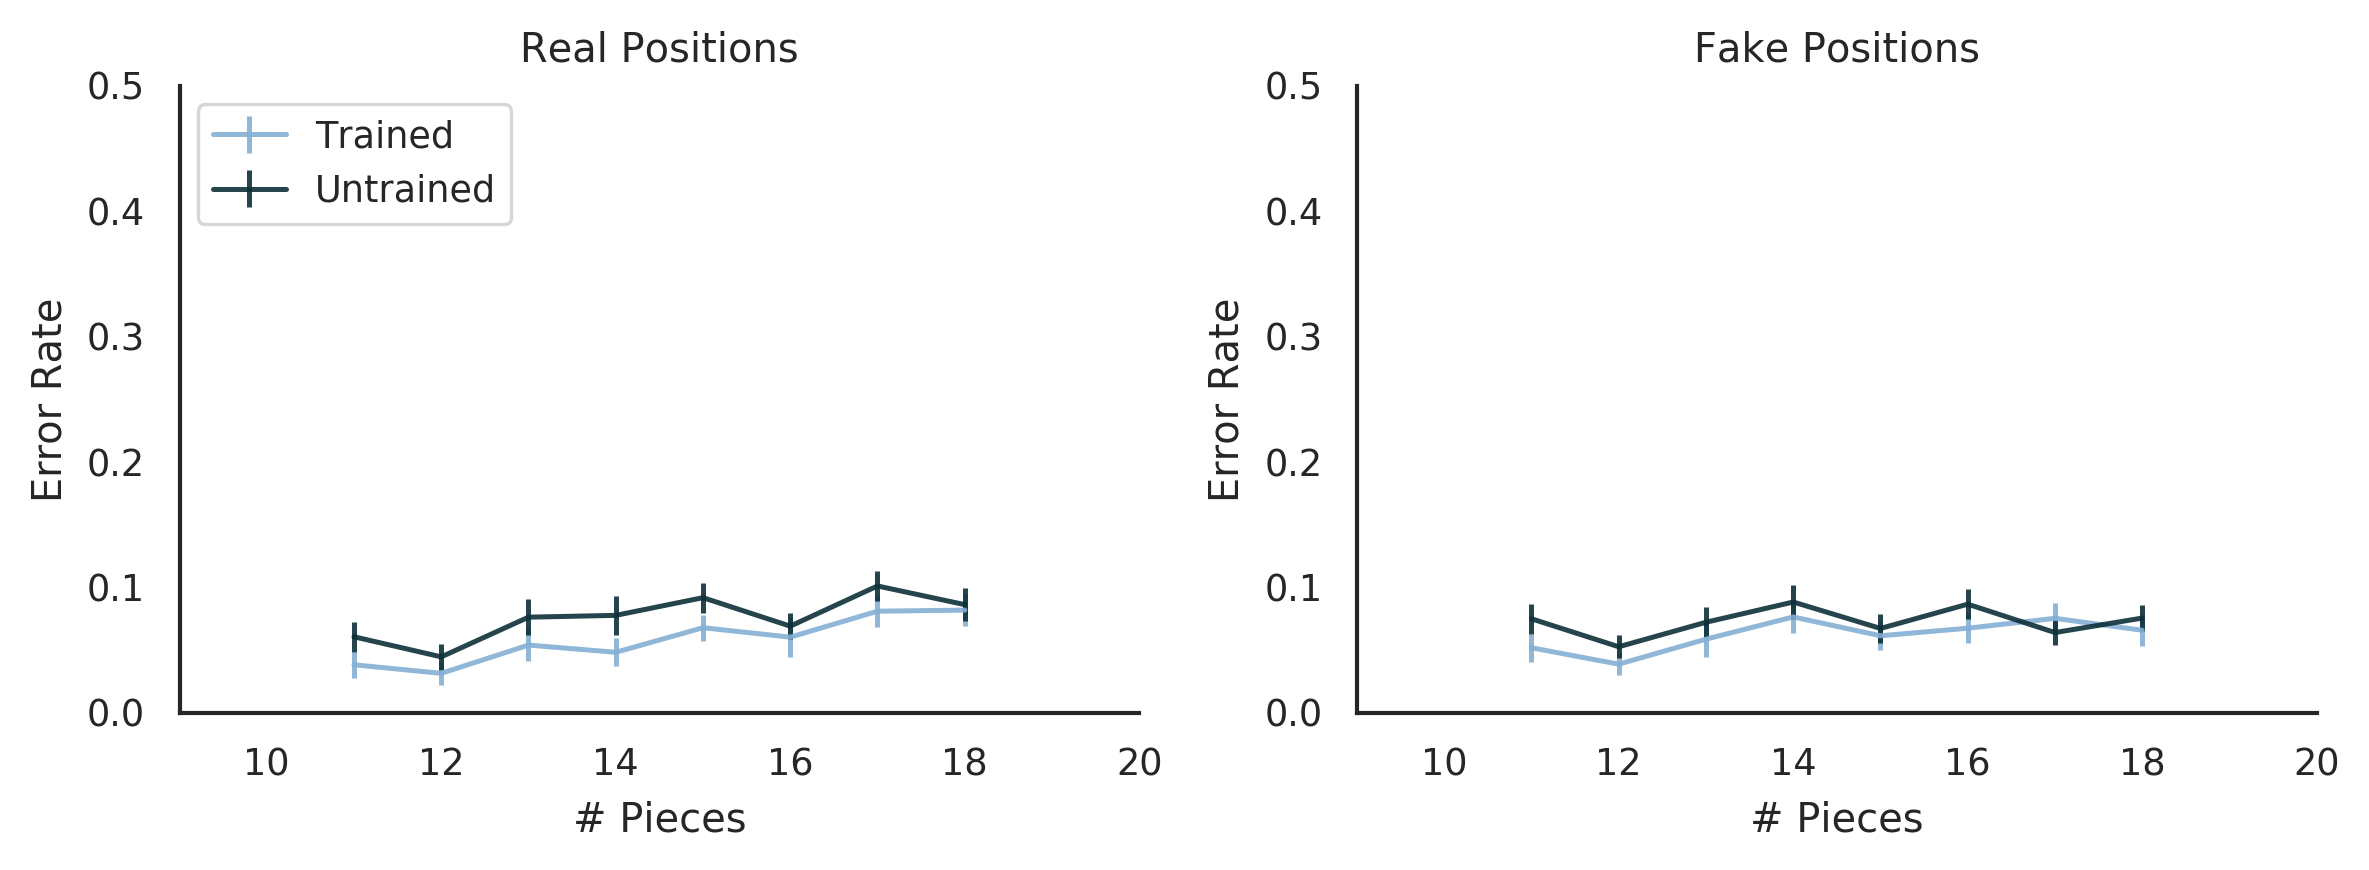

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

## Real

ax = axes[0]

#### Trained

errbar_plot(tidy.loc[tc_filter & tp_filter], ax, 'Trained')

#### Untrained

errbar_plot(tidy.loc[~tc_filter & tp_filter], ax, 'Untrained')

## Fake

ax = axes[1]

#### Trained

errbar_plot(tidy.loc[tc_filter & ~tp_filter], ax, 'Trained')

#### Untrained

errbar_plot(tidy.loc[~tc_filter & ~tp_filter], ax, 'Untrained')

# Style

axes[0].legend(loc=2)

plt.setp(
    axes, 
    xlabel='# Pieces', ylabel='Error Rate', 
    xlim=[9, 20], ylim=[0, .5]
)

plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()
plt.tight_layout()

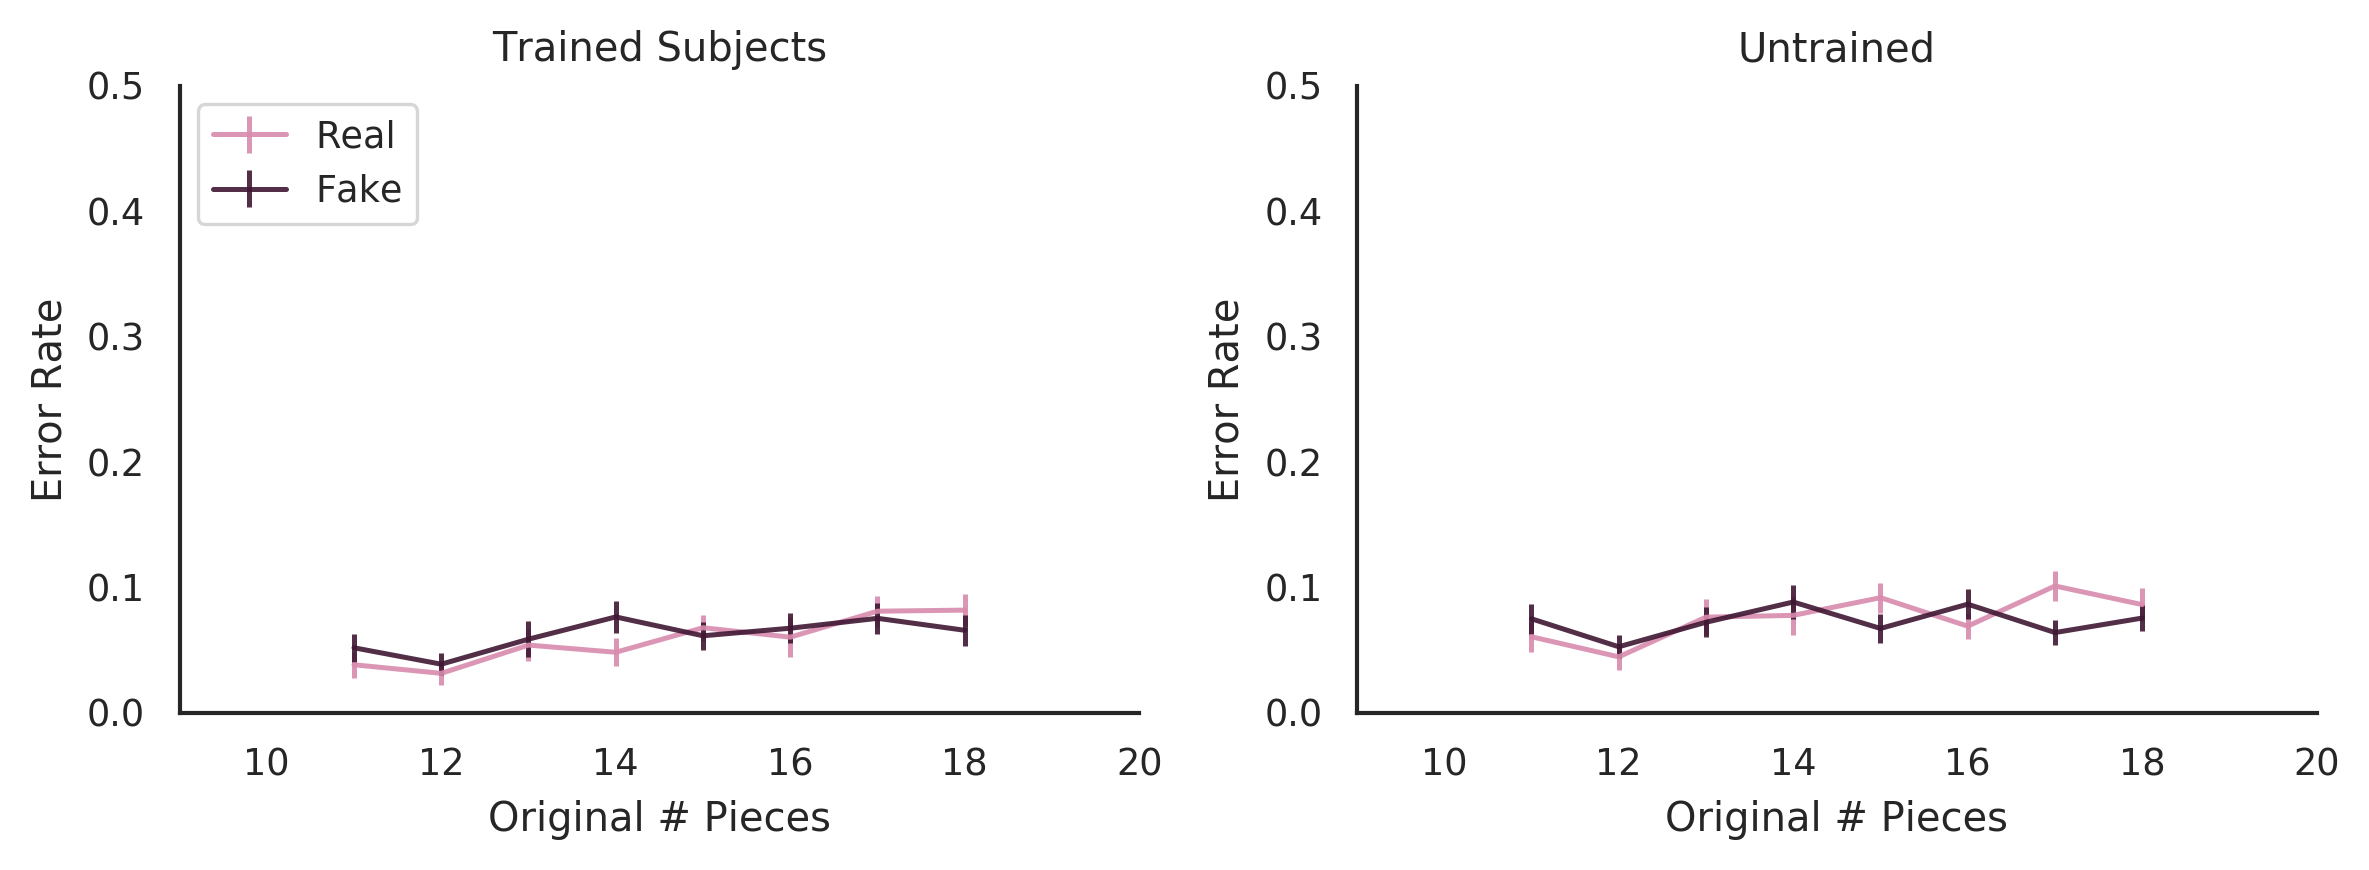

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

## Trained

ax = axes[0]

#### Real
errbar_plot(tidy.loc[tc_filter & tp_filter], ax, 'Real')

#### Fake
errbar_plot(tidy.loc[tc_filter & ~tp_filter], ax, 'Fake')

## Untrained

ax = axes[1]

#### Real
errbar_plot(tidy.loc[~tc_filter & tp_filter], ax, 'Real')

#### Untrained

errbar_plot(tidy.loc[~tc_filter & ~tp_filter], ax, 'Fake')

# Style

axes[0].legend(loc=2)

plt.setp(
    axes, 
    xlabel='Original # Pieces', ylabel='Error Rate', 
    xlim=[9, 20], ylim=[0, .5]
)
plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()
plt.tight_layout()

# Regression

In [10]:
NBFam = sm.families.NegativeBinomial()


class PerSubjectRegress(object):
    def __call__(self, condition='Trained', is_real=True):
        support = np.arange(0, 36, .2)

        models = []
        c = tidy['Condition'] == condition
        r = tidy['Is Real'] == is_real

        T = tidy.loc[c & r]

        for subject_id in T['Subject ID'].unique():
            p = T['Subject ID'] == subject_id
            S = T.loc[p]

            model = self.get_fitted_model(data=S)
            models.append(model)

        params = pd.DataFrame([m.params for m in models], index=T['Subject ID'].unique())
        params['prediction'] = [m.predict(exog=np.stack([support, np.ones_like(support)]).T) for m in models]
        params['Condition'] = condition
        params['Is Real'] = is_real

        return params, models
    

class NBRRegress(PerSubjectRegress):
    def get_fitted_model(self, data):
        glm = smf.glm(formula='y ~ x', data=data, family=NBFam)
        return glm.fit(method='bfgs', maxiter=10000)
        

        

class LogisticRegress(PerSubjectRegress):
    def get_fitted_model(self, data):
        x = data['x']
        x_intercept = np.ones_like(x)
        x = np.stack([x, x_intercept]).T
        y = data['y']
        
        model = sm.Logit(y, x)
        return model.fit()
    
    
nbr_regress = NBRRegress()
logistic_regress = LogisticRegress()

In [11]:
param_dfs = []
models_list = []

for condition in ['Trained', 'Untrained']:
    for is_real in [True, False]:
        param_df, models = logistic_regress(condition=condition, is_real=is_real)
        param_dfs.append(param_df)
        models_list.append(models)
        
        
params = pd.concat(param_dfs)

Optimization terminated successfully.
         Current function value: 0.064411
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127527
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.046354
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.092750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062172
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.236095
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.113102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.345460
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.026467
  

In [12]:
params.head()

,x1,const,prediction,Condition,Is Real
1456159044009,0.170618,-5.633721,"[0.0035625113550302547, 0.0036857191536133404,...",Trained,True
1460648046964,0.073126,-3.635789,"[0.025685973174785205, 0.026054534430152293, 0...",Trained,True
1461251706926,0.234693,-6.944592,"[0.000962905754584752, 0.001009133997380026, 0...",Trained,True
1455999209774,0.191287,-5.224504,"[0.005354206253602463, 0.0055618515585821576, ...",Trained,True
1461278859277,0.049926,-3.544899,"[0.028061366111900306, 0.02833499083309583, 0....",Trained,True


In [13]:
params_condition_filter = params['Condition'] == 'Trained'
params_position_filter = params['Is Real']

support = np.arange(0, 36, .2)

def get_fitted_lines(params_df):
    for i, row in enumerate(params_df.iterrows()):
        fit = row[1]['prediction']
        
        yield fit
        
        
def plot_regression(df, ax, label, **kwargs):
    base = np.stack([y_vals for y_vals in get_fitted_lines(df)])
    
    mean = base.mean(axis=0)
    sem = base.std(axis=0) / np.sqrt(base.shape[0])
    lower, upper = mean - sem, mean + sem
    
    ax.plot(support, mean, color=colors[label.lower()], label=label)
    ax.fill_between(support, lower, upper, facecolor=colors[label.lower()], alpha=.4, edgecolor='white')
    
    return None
    

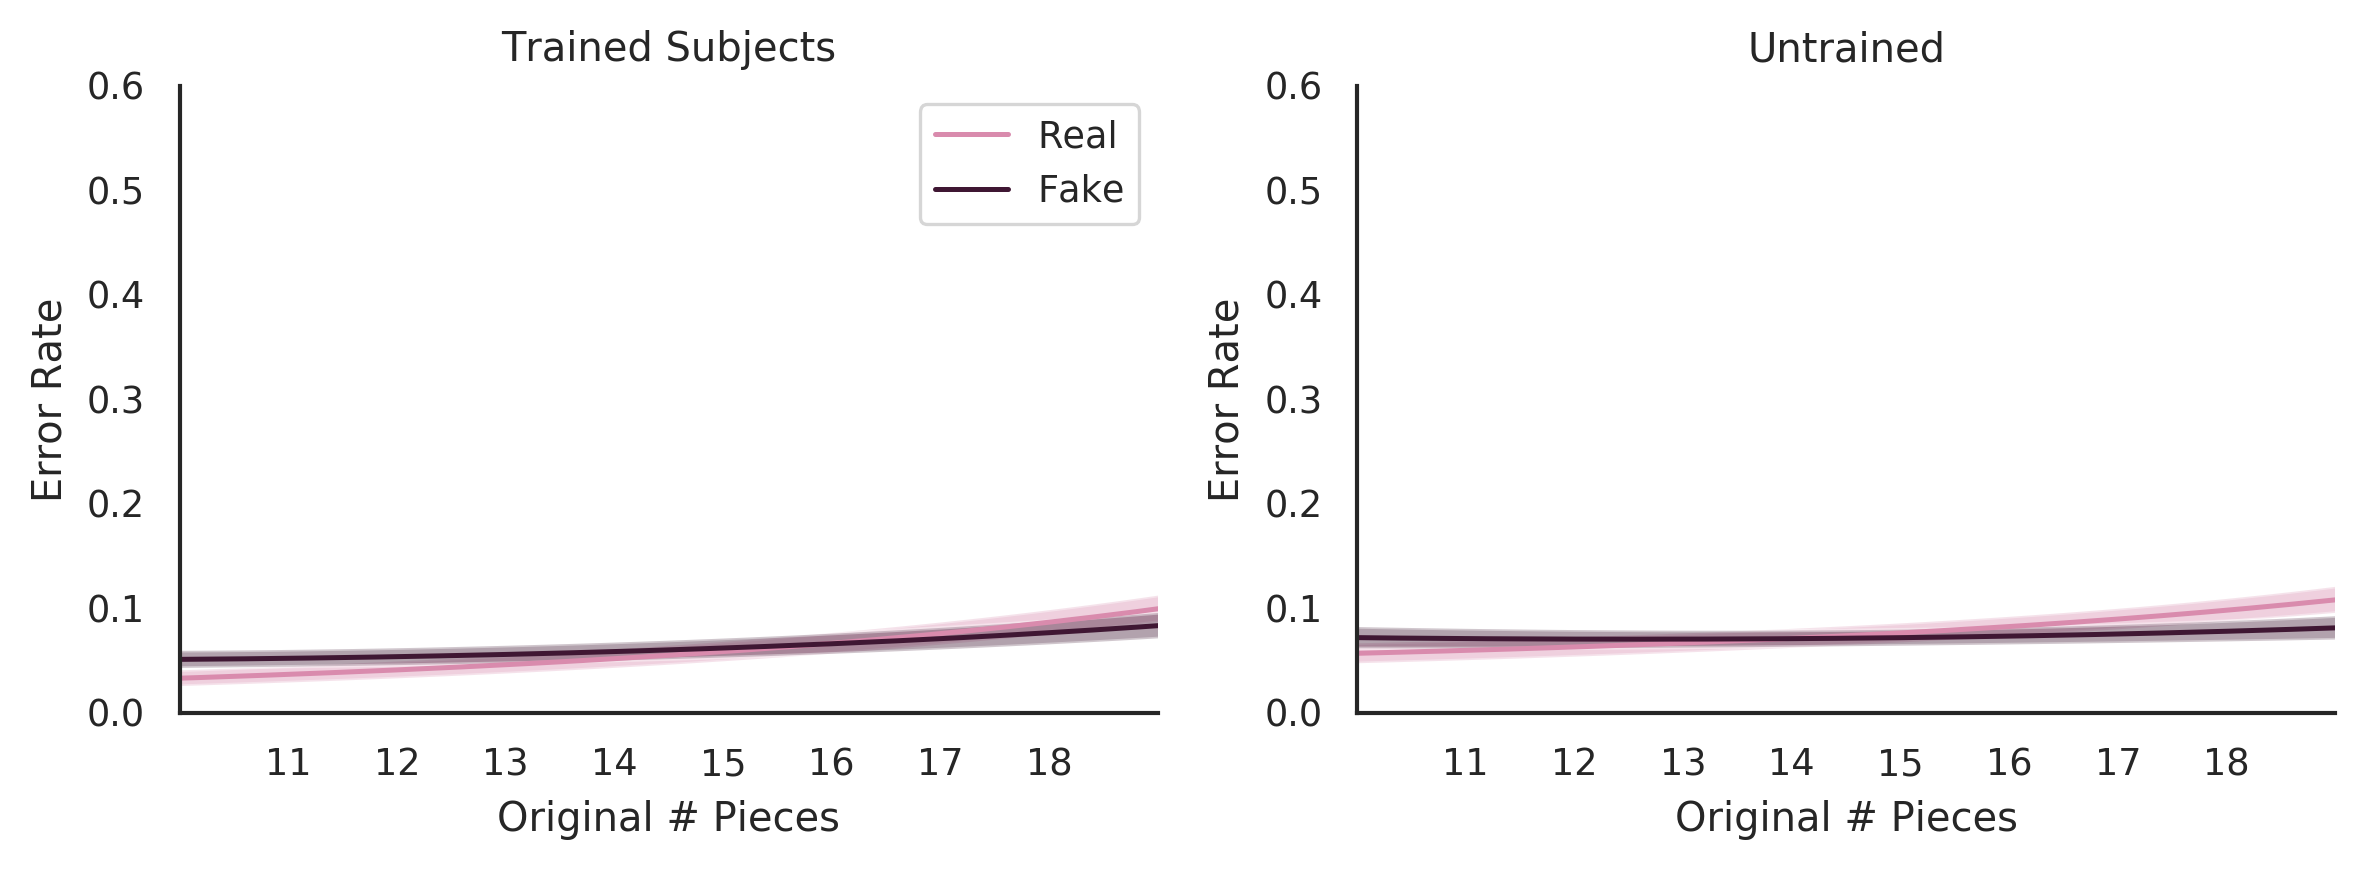

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

# Trained 

ax = axes[0]

### Real
p = params.loc[params_condition_filter & params_position_filter]
plot_regression(p, ax, 'Real')
    
### Fake
p = params.loc[params_condition_filter & ~params_position_filter]
plot_regression(p, ax, 'Fake')

# Untrained 

ax = axes[1]

### Real
p = params.loc[~params_condition_filter & params_position_filter]
plot_regression(p, ax, 'Real')

    
### Fake
p = params.loc[~params_condition_filter & ~params_position_filter]
plot_regression(p, ax, 'Fake')
    
# Style

axes[0].legend(loc=0)

plt.setp(
    axes, 
    ylabel='Error Rate', xlabel='Original # Pieces', 
    xlim=[10, 19], ylim=[0, .6],
    xticks=np.arange(11, 19, 1), xticklabels=np.arange(11, 19, 1),
)

plt.setp(axes[0], title='Trained Subjects')
plt.setp(axes[1], title='Untrained')

sns.despine()
plt.tight_layout()

In [15]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'MEAN CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        outputs.loc[idx, col] = g.apply(
            lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['y'].values)[0, 1]
        ).mean()

outputs

MEAN CORRCOEF,False,True
Trained,0.0929862,0.191966
Untrained,0.0236189,0.122587


In [16]:
idx_names = ['Trained', 'Untrained']
col_names = [False, True]

outputs = pd.DataFrame(index=idx_names, columns=col_names)
outputs.columns.name = 'SEM CORRCOEF'


for idx in idx_names:
    for col in col_names:
        f_idx = tidy['Condition'] == idx
        f_col = tidy['Is Real'] == col
        g = tidy.loc[f_idx & f_col].groupby('Subject ID')
        corcoefs = g.apply(lambda g_: np.corrcoef(g_['Num Pieces'].values, g_['y'].values)[0, 1])
        outputs.loc[idx, col] = corcoefs.std() / np.sqrt(len(corcoefs))
outputs

SEM CORRCOEF,False,True
Trained,0.0345226,0.0233417
Untrained,0.0364648,0.0284831


In [17]:
val = 'x1'

In [18]:
means = params.pivot_table(
    index='Condition', values=val, columns='Is Real',
    aggfunc=np.mean
)

means.columns.name='MEANS'
means.index.name = None
means

MEANS,False,True
Trained,0.064085,0.157345
Untrained,0.014826,0.094829


In [19]:
sems = params.pivot_table(
    index='Condition', values=val, columns='Is Real',
    aggfunc=lambda x: x.std() / np.sqrt(len(x))
)

sems.columns.name = 'SEMS'
sems.index.name = None
sems

SEMS,False,True
Trained,0.030256,0.021455
Untrained,0.022245,0.026077


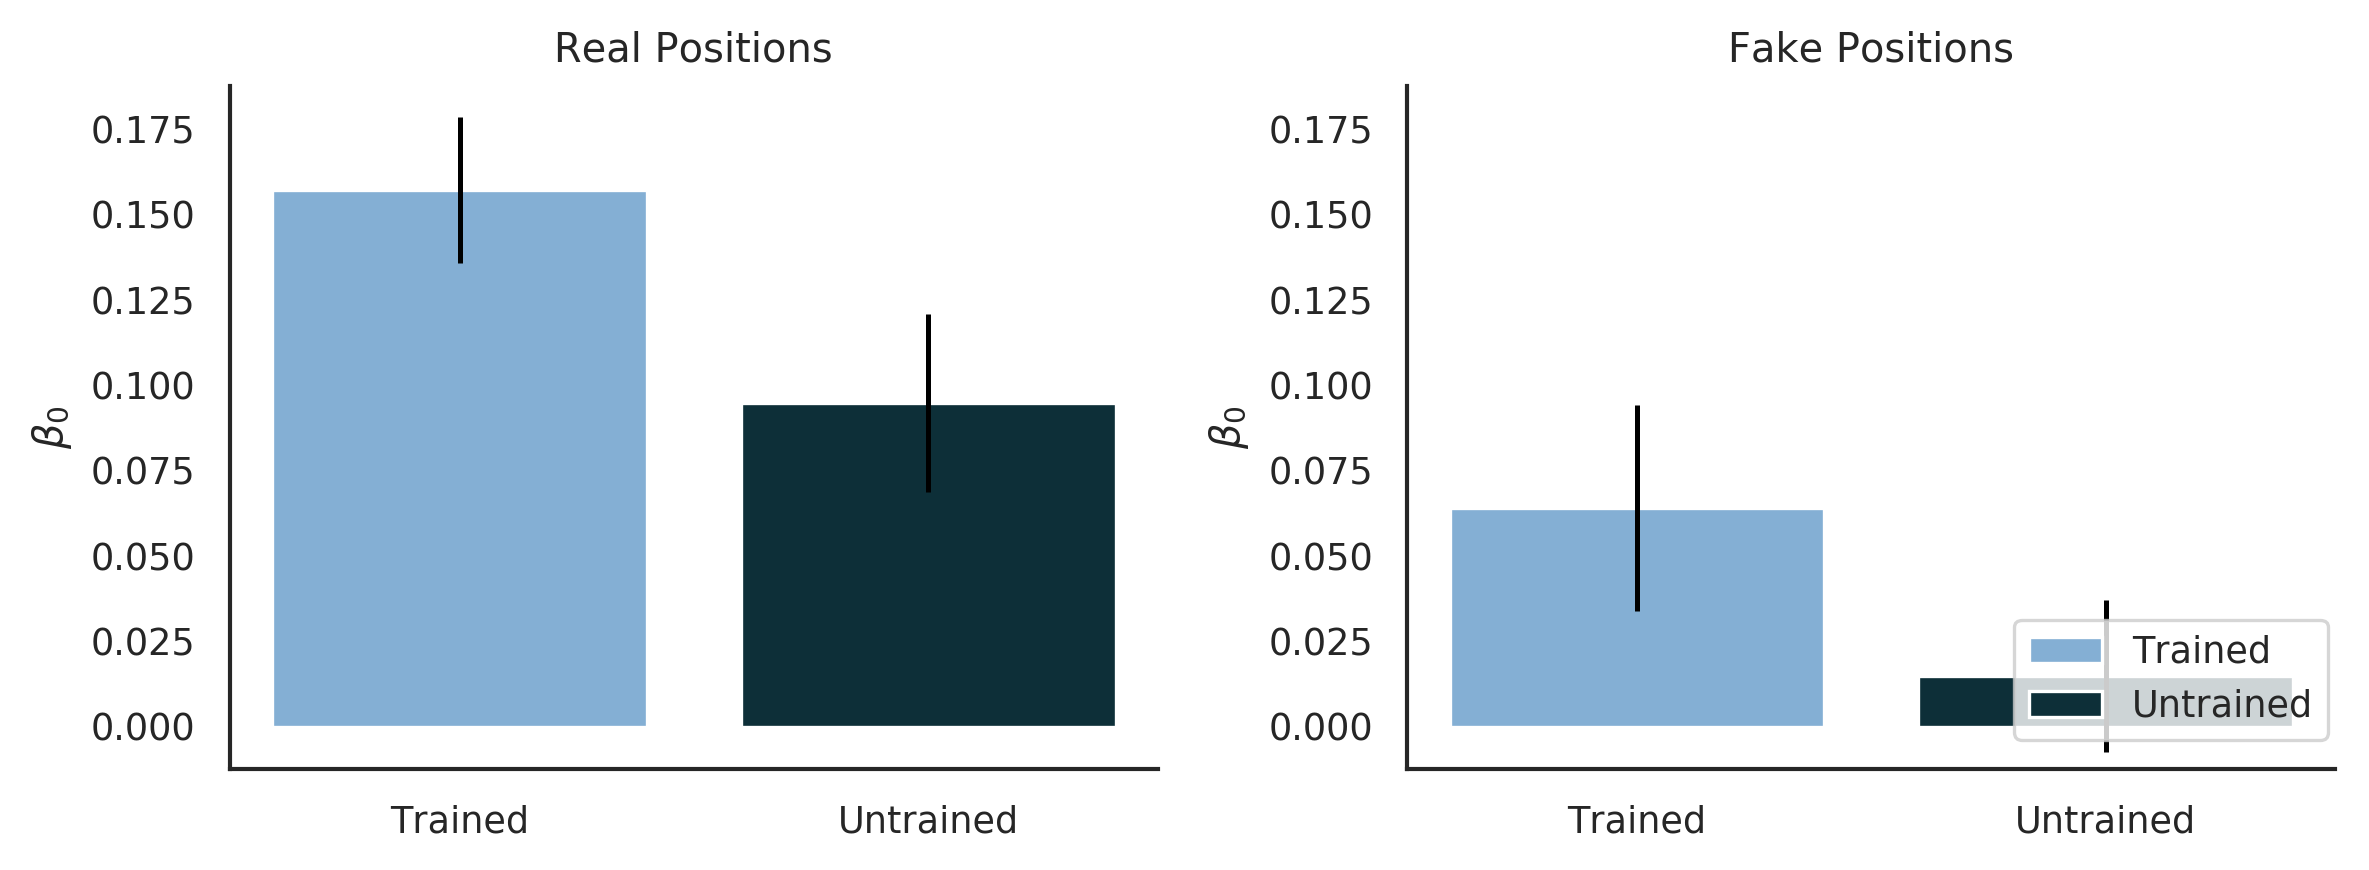

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

axes[0].bar([0], means.loc['Trained', True], color=colors['trained'], label='Trained')
axes[0].bar([1], means.loc['Untrained', True], color=colors['untrained'], label='Untrained')
axes[0].errorbar([0], means.loc['Trained', True], yerr=sems.loc['Trained', True], color='black')
axes[0].errorbar([1], means.loc['Untrained', True], yerr=sems.loc['Untrained', True], color='black')

axes[1].bar([0], means.loc['Trained', False], color=colors['trained'])
axes[1].bar([1], means.loc['Untrained', False], color=colors['untrained'])
axes[1].errorbar([0], means.loc['Trained', False], yerr=sems.loc['Trained', False], color='black')
axes[1].errorbar([1], means.loc['Untrained', False], yerr=sems.loc['Untrained', False], color='black')

plt.figlegend(loc=(.85, .15))

ylim =[
    min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), 
    max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
]

# axes[0].plot([-.5, 1.5], [0, 0], color='black', linestyle='--')
# axes[1].plot([-.5, 1.5], [0, 0], color='black', linestyle='--')


plt.setp(
    axes,
    ylim=ylim, 
    ylabel=r'$\mathit{\beta_0}$',
    xticks=[0, 1], xticklabels=['Trained', 'Untrained']
)

plt.setp(axes[0], title='Real Positions')
plt.setp(axes[1], title='Fake Positions')

sns.despine()
plt.tight_layout()

In [21]:
c = params['Condition'] == 'Trained'
r = params['Is Real'] == True

In [22]:
# One sample t test for significance of parameter

pvalues = params.pivot_table(
    index='Condition', values=val, columns='Is Real', 
    aggfunc=lambda x: sts.ttest_1samp(x, 0).pvalue
)

pvalues.columns.name = 'PVALUES'
pvalues.index.name = None
pvalues

PVALUES,False,True
Trained,0.048340,8.262369e-07
Untrained,0.513554,1.887537e-03


In [23]:
# Two sample t test for between group differences
results = pd.DataFrame()

results.loc['Condition', 'True'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[~c & r, val].values).pvalue
results.loc['Condition', 'False'] = sts.ttest_ind(params.loc[c & ~r, val].values, params.loc[~c & ~r, val].values).pvalue

results.loc['Position Type', 'Trained'] = sts.ttest_ind(params.loc[c & r, val].values, params.loc[c & ~r, val].values).pvalue
results.loc['Position Type', 'Untrained'] = sts.ttest_ind(params.loc[~c & r, val].values, params.loc[~c & ~r, val].values).pvalue

results.columns.name = 'PVALUES\tConstant'
results.index.name = 'Variable'
results

PVALUES Constant,True,False,Trained,Untrained
Variable,,,,
Condition,0.072342,0.197921,NaN,NaN
Position Type,NaN,NaN,0.016534,0.025291


In [24]:
tidy['y'].unique().size

65

In [25]:
# tidy['y'] = tidy['Type I Errors'] / (36 - tidy['Num Pieces'])
tidy['y'] = tidy['Type II Errors'] / tidy['Num Pieces']
# tidy['y'] = tidy['Type III Errors'] / tidy['Num Pieces']

bins = np.arange(0, 1, .05)

def bin_y_val(y):
    return bins[bins <= y].max()

tidy['binned_y'] = tidy['y'].map(bin_y_val)

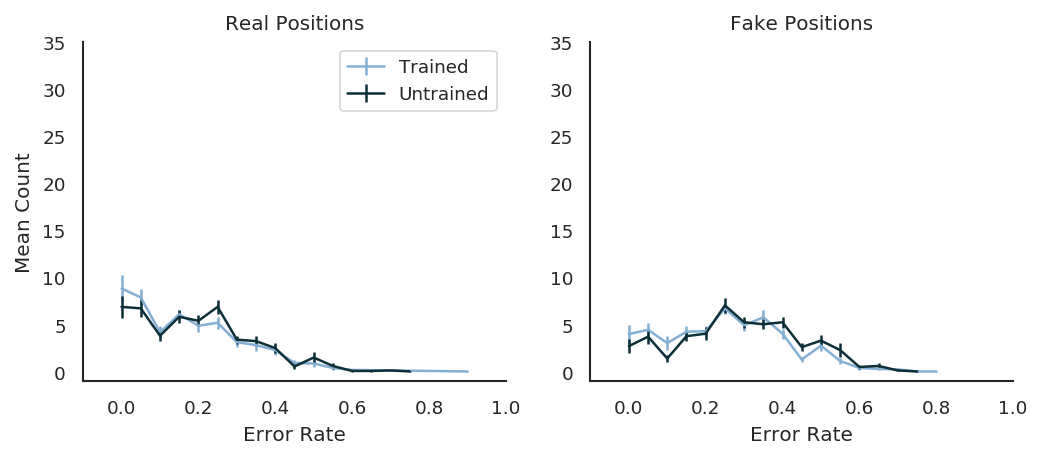

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

tc_filter = tidy['Condition'] == 'Trained'
tp_filter = tidy['Is Real'] == True

def error_rate_hist(df, ax, **kwargs):
    piv = df.pivot_table(
        index='Subject ID', columns='binned_y', values='Position ID', 
        aggfunc=len, fill_value=0
    )

    x = piv.columns.values
    y = piv.mean(axis=0)
    err = piv.std(axis=0) / np.sqrt(len(piv))

    ax.errorbar(x, y, yerr=err, **kwargs)
    
    return None

ax = axes[0]

error_rate_hist(
    tidy.loc[tc_filter & tp_filter], 
    ax=ax, color=colors['trained'], label='Trained'
)

error_rate_hist(
    tidy.loc[~tc_filter & tp_filter], 
    ax=ax, color=colors['untrained'], label='Untrained'
)

error_rate_hist(
    tidy.loc[tc_filter & ~tp_filter], 
    ax=axes[1], color=colors['trained'], label='Trained'
)

error_rate_hist(
    tidy.loc[~tc_filter & ~tp_filter], 
    ax=axes[1], color=colors['untrained'], label='Untrained'
)


## Make it fancy

axes[0].legend(loc=0)

plt.setp(axes, xlim=[-.1, 1], ylim=[-1, 35], xlabel='Error Rate')
plt.setp(axes[0], title='Real Positions', ylabel='Mean Count')
plt.setp(axes[1], title='Fake Positions', ylabel='')
sns.despine()

In [27]:
trained_piv = tidy.loc[tc_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

untrained_piv = tidy.loc[~tc_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

real_piv = tidy.loc[tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

fake_piv = tidy.loc[~tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

columns = set()
piv_list = [trained_piv, untrained_piv, real_piv, fake_piv]
for piv in piv_list:
    columns = columns.union(set(piv.columns.tolist()))
    
for piv in piv_list:
    absent = columns - set(piv.columns.tolist())
    for a in absent:
        piv[a] = 0

freq_table = np.stack([trained_piv.sum(axis=0).values, untrained_piv.sum(axis=0).values])
chisq, p, dof, ex = sts.chi2_contingency(freq_table) #, lambda_="log-likelihood")
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

freq_table = np.stack([real_piv.sum(axis=0).values, fake_piv.sum(axis=0).values])[:, :-1]
chisq, p, dof, ex = sts.chi2_contingency(freq_table)
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

Chi-square test result: 44.08, p=0.0003
Chi-square test result: 306.09, p=0.0000


In [47]:
real_trained_piv = tidy.loc[tc_filter & tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

real_untrained_piv = tidy.loc[~tc_filter & tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

fake_trained_piv = tidy.loc[tc_filter & ~tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

fake_untrained_piv = tidy.loc[~tc_filter & ~tp_filter].pivot_table(
    index='Subject ID', columns='binned_y', values='Position ID', 
    aggfunc=len, fill_value=0
)

columns = set()
piv_list = [real_trained_piv, real_untrained_piv, fake_trained_piv, fake_untrained_piv]
for piv in piv_list:
    columns = columns.union(set(piv.columns.tolist()))
    
for piv in piv_list:
    absent = columns - set(piv.columns.tolist())
    for a in absent:
        piv[a] = 0

freq_table = np.stack([real_trained_piv.sum(axis=0).values, real_untrained_piv.sum(axis=0).values])
freq_table = freq_table[:, freq_table.sum(axis=0) > 0]
chisq, p, dof, ex = sts.chi2_contingency(freq_table)
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

freq_table = np.stack([fake_trained_piv.sum(axis=0).values, fake_untrained_piv.sum(axis=0).values])[:, :-1]
freq_table = freq_table[:, freq_table.sum(axis=0) > 0]
chisq, p, dof, ex = sts.chi2_contingency(freq_table)
print('Chi-square test result: {:.2f}, p={:.4f}'.format(chisq, p))

Chi-square test result: 23.26, p=0.0788
Chi-square test result: 42.26, p=0.0004


In [48]:
piv = tidy.loc[tc_filter & tp_filter].pivot_table(
    index='Subject ID', columns='y', values='Position ID', 
    aggfunc=len, fill_value=0
)

x = piv.columns.values
y = piv.mean(axis=0)
err = piv.std(axis=0) / np.sqrt(len(piv))

In [49]:
bins = np.arange(0, 1, .05)

bins[bins <= .08].max()

0.05

In [69]:
trained_piv = tidy.loc[tc_filter].pivot_table(
    index='y', values='Position ID', 
    aggfunc=len, fill_value=0
)

untrained_piv = tidy.loc[~tc_filter].pivot_table(
    index='y',values='Position ID', 
    aggfunc=len, fill_value=0
)

real_piv = tidy.loc[tp_filter].pivot_table(
    index='y', values='Position ID', 
    aggfunc=len, fill_value=0
)

fake_piv = tidy.loc[~tp_filter].pivot_table(
    index='y',values='Position ID', 
    aggfunc=len, fill_value=0
)

columns = set()
piv_list = [trained_piv, untrained_piv, real_piv, fake_piv]
for piv in piv_list:
    columns = columns.union(set(piv.columns.tolist()))
    
for piv in piv_list:
    absent = columns - set(piv.columns.tolist())
    for a in absent:
        piv[a] = 0


In [72]:
len(trained_piv)

73

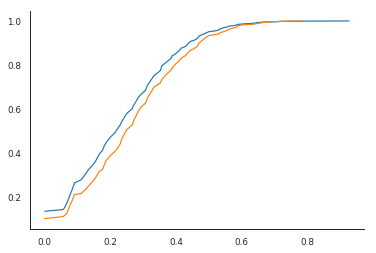

In [81]:
plt.plot(normed_trained_df.cumsum())
plt.plot(normed_untrained_df.cumsum())
sns.despine()

In [85]:
normed_trained_df = (trained_piv / trained_piv.sum())
normed_untrained_df = (untrained_piv / untrained_piv.sum())
normed_real_df = real_piv / real_piv.sum()
normed_fake_df = fake_piv / fake_piv.sum()

sts.ks_2samp(normed_real_df['Position ID'], normed_fake_df['Position ID'])

KeyError: 'Position ID'

In [61]:
tidy.head()

,Subject ID,Initials,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Num Dif,x,y,binned_y
0,1456159044009,EN,Trained,0,73,True,100000000001011010000111000000000000,000000000010100000001000100000110100,100000000001011000000111010000000000,000000000010000100001000100000110000,29.386,8,7,15,2,3,5.0,1,1,2,1,2,3,0,0,0,14,1,-1,15,0.200000,0.20
2,1456159044009,EN,Trained,1,44,False,000010000100100011001101000000001000,000100000010001100000000000011010110,000010000000100000001100000000000000,000000000000000000000000000001101000,22.307,9,9,18,5,10,14.0,0,1,1,4,8,12,1,0,1,7,11,-11,18,0.666667,0.65
4,1456159044009,EN,Trained,2,91,True,000100010001011100000011000000100000,000011100000100010000100100000010100,000000000000011000000011000000100000,000011100000100010000000100000010100,18.043,9,9,18,4,1,5.0,0,0,0,4,1,5,0,0,0,13,5,-5,18,0.277778,0.25
6,1456159044009,EN,Trained,3,62,True,010001000000100000011100000000010000,000110000000010000100011000000000000,000000000010100000001000000001100000,000110000000010000000011000000000000,22.109,7,6,13,8,1,9.0,3,0,3,5,1,6,0,0,0,10,3,-3,13,0.461538,0.45
8,1456159044009,EN,Trained,4,54,True,000010000000001000000000000011010010,100100000000000000000010100100100000,000000000000100000000111000000000000,100100000000010000000000000100100100,23.413,6,6,12,10,4,13.0,3,2,5,6,1,7,0,1,1,10,2,-2,12,0.583333,0.55
